# Прогноз оттока клиентов сети фитнес-центров


<b>Цель проекта</b>
    
На основании данных по клиентам сети фитнес-центров, спрогнозировать вероятность оттока для каждого клиента. Сформировать типичные портреты клиентов, охарактеризовать их основные свойства. Проанализировать основные признаки, наиболее сильно влияющие на отток и разработать рекомендации по повышению качества работы с клиентами.


    
<b>Требуемые шаги:</b>   
    
<b>Исследовательский анализ данных (EDA)</b> 
<li>предобработка данных</li>
<li>определить средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался</li>
<li>построить столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался</li>
<li>построить матрицу корреляций </li>

<b>Построение модели прогнозирования оттока клиентов</b> 
<li>построить модель бинарной классификации клиентов</li>
<li>разбить данные на обучающую и валидационную выборку и обучить двумя способами: логистической регрессией и случайным лесом</li>
<li>оценить метрики accuracy, precision и recall для обеих моделей на валидационной выборке и сравнить по ним модели</li>

<b>Кластеризация клиентов</b> 
<li>провести стандартизацию данных</li>
<li>построить матрицу расстояний на стандартизованной матрице признаков и нарисовать дендрограмму</li>
<li>обучить модель кластеризации на основании алгоритма K-Means и спрогнозировать кластеры клиентов</li>
<li>определить средние значения признаков для кластеров</li>
<li>построить распределения признаков для кластеров</li>
<li>для каждого полученного кластера посчитать долю оттока</li>
    
На основании полученного анализа предложить рекомендации для стратегии взаимодействия с клиентами и их удержания.


## Исследовательский анализ данных (EDA)

**Импорт библиотек**

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from scipy import stats as st
from plotly import graph_objects as go
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score
from scipy.cluster.hierarchy import dendrogram, linkage 
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

**Откроем файл и изучим данные**

In [2]:
try:
    gym_churn = pd.read_csv('/datasets/gym_churn.csv')
except:
    gym_churn = pd.read_csv('gym_churn.csv')
gym_churn.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [3]:
gym_churn.rename(columns={"gender": "Gender"}, inplace=True)

Определим размер датасета:

In [4]:
gym_churn.shape

(4000, 14)

Датасет размером 4000 строк и 14 столбцов, из них 13 столбцов с признаками и один столбец с целевой переменной - Churn (отток). Посмотрим общую информацию о датасете:

In [5]:
gym_churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

Пропуски отсутствуют.
Половина признаков категориальные: пол (Gender), проживание или работа в том же районе (Near_Location), сотрудник компании-партнёра (Partner), запись в рамках акции «приведи друга» (Promo_friends), наличие контактного телефона (Phone), факт посещения групповых занятий (Group_visits). Данные признаки уже приобразованы в числовые значения (принимают 0 или 1) и не требуют дополнительной обработки. 
Числовые признаки представляют поля: длительность текущего действующего абонемента (Contract_period), возраст (Age), суммарная выручка от других услуг фитнес-центра (Avg_additional_charges_total), срок до окончания текущего действующего абонемента (Month_to_end_contract), время с момента первого обращения в фитнес-центр (Lifetime), средняя частота посещений в неделю за все время с начала действия абонемента (Avg_class_frequency_total), средняя частота посещений в неделю за предыдущий месяц (Avg_class_frequency_current_month).
Целевая переменная и практически все признаки имеют корректный формат. Приведем к целочисленному формату признак Month_to_end_contract (выражается в месяцах):

In [6]:
gym_churn['Month_to_end_contract'] = gym_churn['Month_to_end_contract'].astype('int64')

Определим количество дубликатов:

In [7]:
gym_churn.duplicated().sum()

0

Выведем информацию о параметрах каждого признака:

In [8]:
gym_churn.describe().T

,count,mean,std,min,25%,50%,75%,max
Gender,4000.0,0.510250,0.499957,0.000000,0.000000,1.000000,1.000000,1.000000
Near_Location,4000.0,0.845250,0.361711,0.000000,1.000000,1.000000,1.000000,1.000000
Partner,4000.0,0.486750,0.499887,0.000000,0.000000,0.000000,1.000000,1.000000
Promo_friends,4000.0,0.308500,0.461932,0.000000,0.000000,0.000000,1.000000,1.000000
Phone,4000.0,0.903500,0.295313,0.000000,1.000000,1.000000,1.000000,1.000000
Contract_period,4000.0,4.681250,4.549706,1.000000,1.000000,1.000000,6.000000,12.000000
Group_visits,4000.0,0.412250,0.492301,0.000000,0.000000,0.000000,1.000000,1.000000
Age,4000.0,29.184250,3.258367,18.000000,27.000000,29.000000,31.000000,41.000000
Avg_additional_charges_total,4000.0,146.943728,96.355602,0.148205,68.868830,136.220159,210.949625,552.590740
Month_to_end_contract,4000.0,4.322750,4.191297,1.000000,1.000000,1.000000,6.000000,12.000000


Определим средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался:

In [9]:
churn_mean = gym_churn.groupby(['Churn']).mean() 
churn_mean

,Gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month
Churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


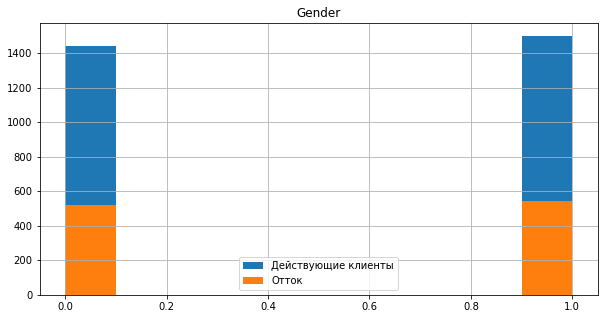

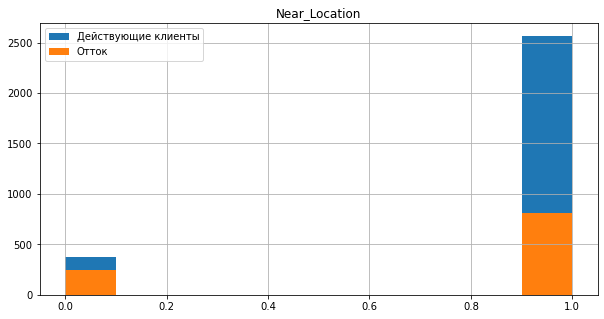

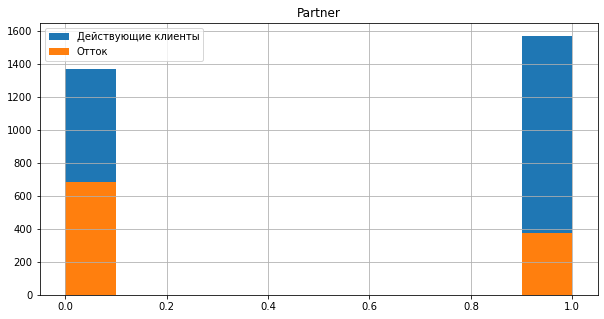

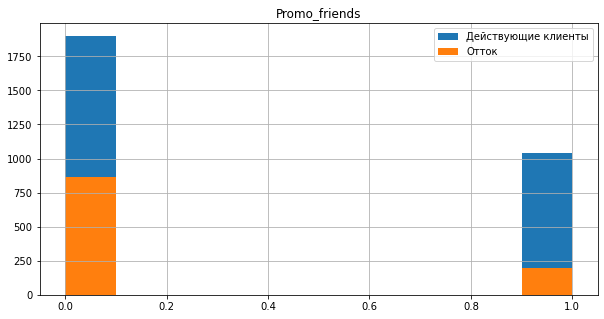

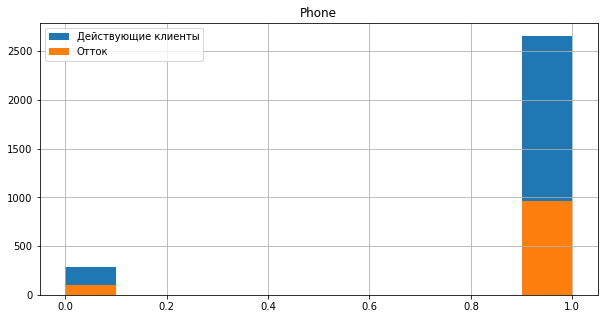

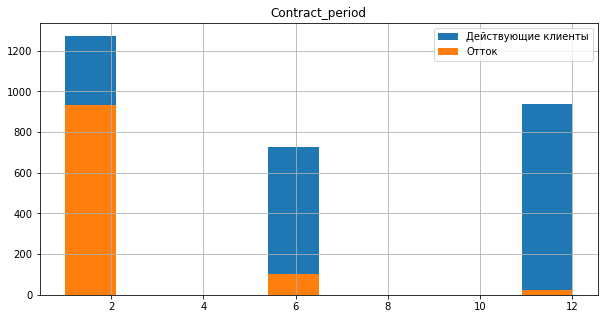

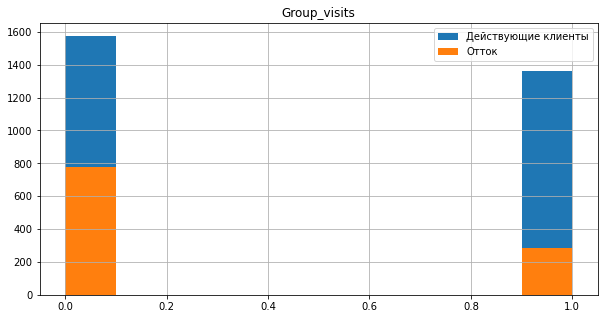

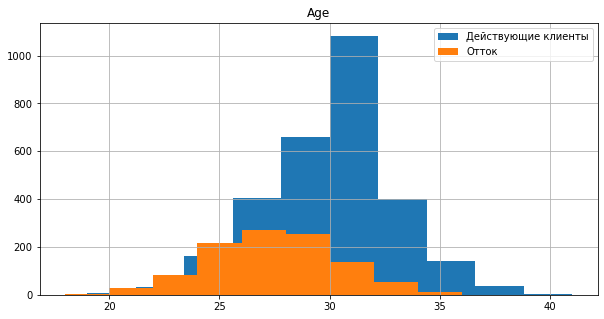

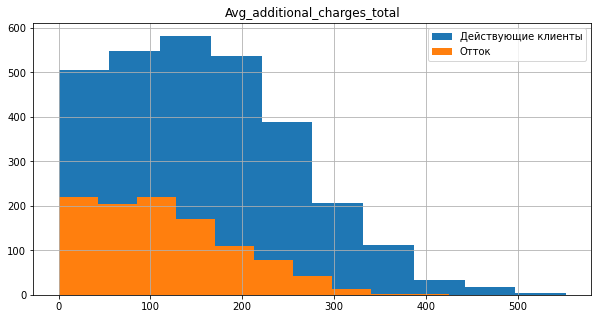

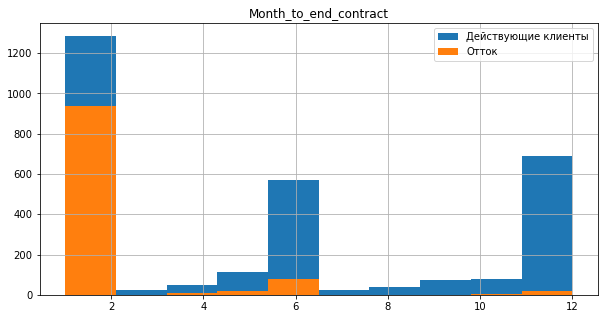

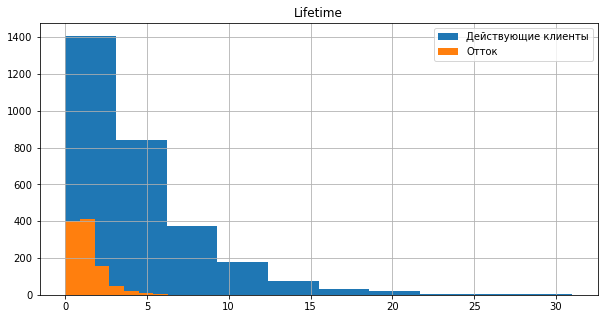

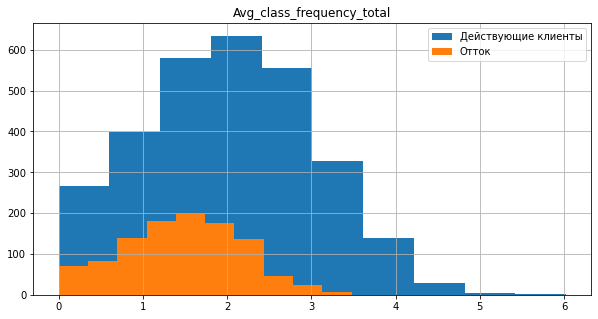

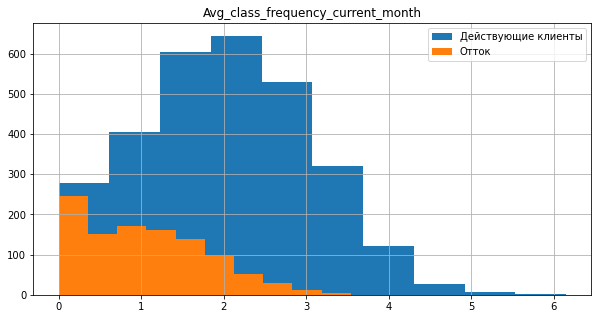

In [10]:
for column in gym_churn.drop('Churn', axis = 1).columns: 
        plt.figure(figsize=(10,5))
        gym_churn.groupby('Churn')[column].hist()
        plt.title(column)
        plt.legend(['Действующие клиенты', 'Отток'])           
        plt.show()

Можно заметить, что пол не влияет на склонность к оттоку, в среднем, практически одинаковое количество мужчин и женщин либо уходят, либо остаётся. Близость расположения фитнес-центра к работе или дому влияет на отток незначительно, скорее всего это связано с тем, что клиенты изначально выбирают клуб неподалёку. Сотрудники компаний-партнёров уходят реже, чем остаются, возможно это обусловлено предпочтением сотрудников ходить "за компанию" с коллегами. По этой же причине обусловлен меньший отток среди клиентов, пришедших по программе "приведи друга". Информация о контактном телефоне никак не влияет на отток (одинаково указана и у тех, и у других). Посещение групповых занятий на отток влияет незначительно - в среднем из ушедших лишь 26,8% занимались в группе. Среднее значение длительности действующего абонемента показывает, что уходят в основном обладатели краткосрочных абонементов (до полугода). Средний возраст ушедших - 27 лет. За дополнительные услуги фитнес-центра платят обе категориии клиентов - в среднем 115 у.е. платят клиенты, ушедшие в отток, и 158 у.е. платят действующие клиенты. Покидают фитнес-центр в среднем за полтора месяца до окончания абонемента. Также можно заметить, что ушедшие в отток клиенты в среднем занимались всего 1 месяц, с периодичностью 1 раз в неделю.

Построим и отобразим матрицу корреляций:

<AxesSubplot:>

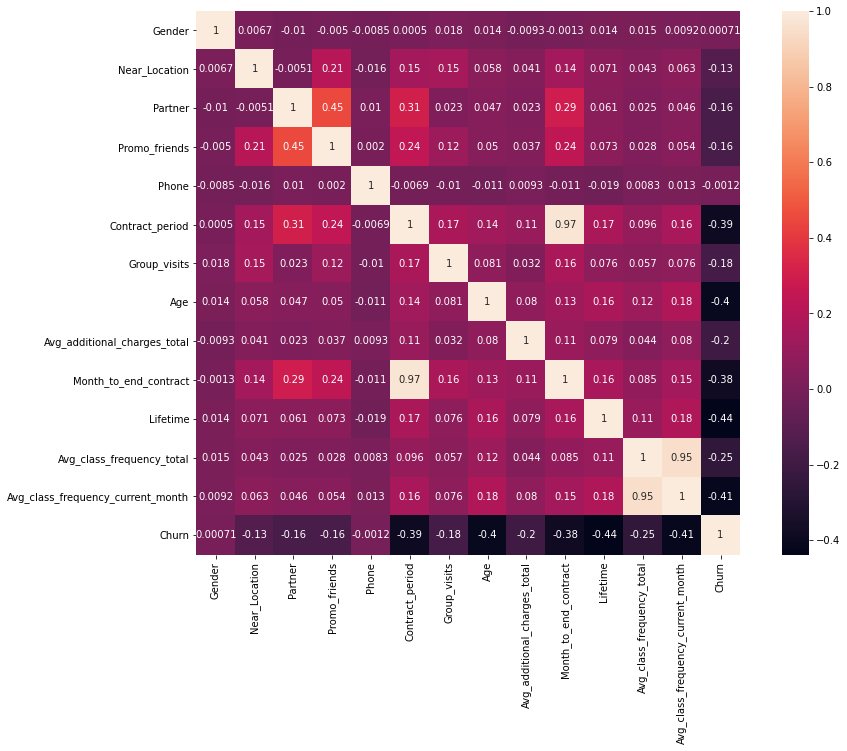

In [11]:
plt.figure(figsize=(15,10))
sns.heatmap(data = gym_churn.corr(), annot = True, square=True) 

Признаков, которые сильно коррелируют с целевой переменной Churn нет. Можно заметить, что имеются признаки, которые попарно коррелируют между собой: Contract_period (длительность действующего абонемента) и Month_to_end_contract (срок до окончания действующего абонемента) а также Avg_class_frequency_total (средняя частота посещений в неделю за все время с начала действия абонемента) и Avg_class_frequency_current_month (средняя частота посещений в неделю за предыдущий месяц).

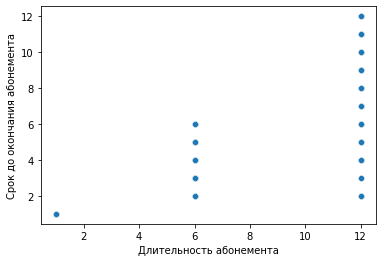

In [12]:
sns.scatterplot(gym_churn['Contract_period'], gym_churn['Month_to_end_contract'])
plt.xlabel("Длительность абонемента")
plt.ylabel("Срок до окончания абонемента")
plt.show()

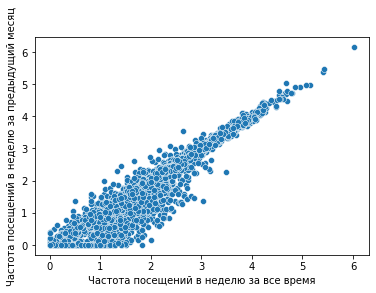

In [13]:
sns.scatterplot(gym_churn['Avg_class_frequency_total'], gym_churn['Avg_class_frequency_current_month'])
plt.xlabel("Частота посещений в неделю за все время")
plt.ylabel("Частота посещений в неделю за предыдущий месяц")
plt.show()


<b>Выводы по исследовательскому анализу данных (EDA):</b>  
<li>данные представлены в корректной форме, пропуски и дубликаты отсутствуют, приведен к целочисленному формату признак "срок до окончания текущего действующего абонемента"</li>
<li>в датасете представлены 13 признаков: 6 категориальных и 7 числовых</li>
<li>целевая переменная определена как Churn (отток)</li>
<li>явно коррелирующих с целевой переменной признаков не обнаружено</li>
<li>обнаружены 2 пары коррелирующих между собой признаков: "длительность действующего абонемента" и "срок до окончания действующего абонемента", а также "средняя частота посещений в неделю за все время с начала действия абонемента" и "средняя частота посещений в неделю за предыдущий месяц"</li>
<li>пол и наличие телефона в базе не влияют на отток</li>
<li>незначительно на отток влияет расположение</li>
<li>клиенты, пришедшие по промо-акциям уходят реже</li>    
<li>реже уходят клиенты, посещающие групповые занятия</li>
<li>возраст между двумя группами различается незначительно</li>    
<li>траты за дополнительные услуги осуществляют обе категории клиентов</li>    
<li>чаще уходят обладатели краткосрочных абонементов (до полугода)</li>     
<li>действующие клиенты посещают клуб в 2 раза чаще</li> 


# Построение модели прогнозирования оттока клиентов

Построим модель бинарной классификации клиентов, где целевой признак — факт оттока клиента в следующем месяце.
Разделим данные на признаки (матрица X) и целевую переменную (y):

In [14]:
X = gym_churn.drop('Churn', axis = 1)
y = gym_churn['Churn']

Разобьем данные на обучающую и валидационную выборку:

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

<AxesSubplot:xlabel='Churn', ylabel='Density'>

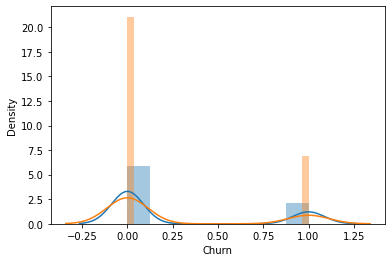

In [16]:
# гистограмма целевой переменной на train
sns.distplot(y_train)
# гистограмма целевой переменной на test
sns.distplot(y_test)

Стандартизируем данные:

In [17]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

Обучим модель на train-выборке логистической регрессией и случайным лесом:

In [18]:
models = [
    LogisticRegression(random_state=0),
    RandomForestClassifier(random_state=0),
]
 
def make_prediction(m, X_train, y_train, X_test, y_test):
    model = m
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(
        'accuracy:{:.2f} precision:{:.2f} recall:{:.2f} '.format(
            accuracy_score(y_test, y_pred),
            precision_score(y_test, y_pred),
            recall_score(y_test, y_pred)
        )
    )    
    
for i in models:
    print(i)
    make_prediction(i, X_train, y_train, X_test, y_test)    

LogisticRegression(random_state=0)
accuracy:0.91 precision:0.84 recall:0.80 
RandomForestClassifier(random_state=0)
accuracy:0.92 precision:0.84 recall:0.82 


Можно заметить, что метрики классификации выше у модели логистической регрессии: правильно прогнозируются 93% ответов против 91% у модели случайного леса. Метрики качества работы алгоритма recall и precision также выше у модели логистической регрессии: 0,86 против 0,83 для метрики полноты, и 0,83 против 0,78 для метрики точности.


<b>Выводы по построению модели прогнозирования оттока клиентов:</b>  
<li>целевой признак — факт оттока клиента в следующем месяце</li>
<li>для сравнения использовались две модели: логистическая регрессия и случайный лес</li>    
<li>по результатам обучения можно заключить, что модель логистической регрессии показала себя точнее по всем метрикам классификации</li>    


# Кластеризация клиентов

Стандартизируем данные:

In [19]:
sc = StandardScaler()
X_sc = sc.fit_transform(X)

Построим матрицу расстояний и нарисуем дендрограмму:

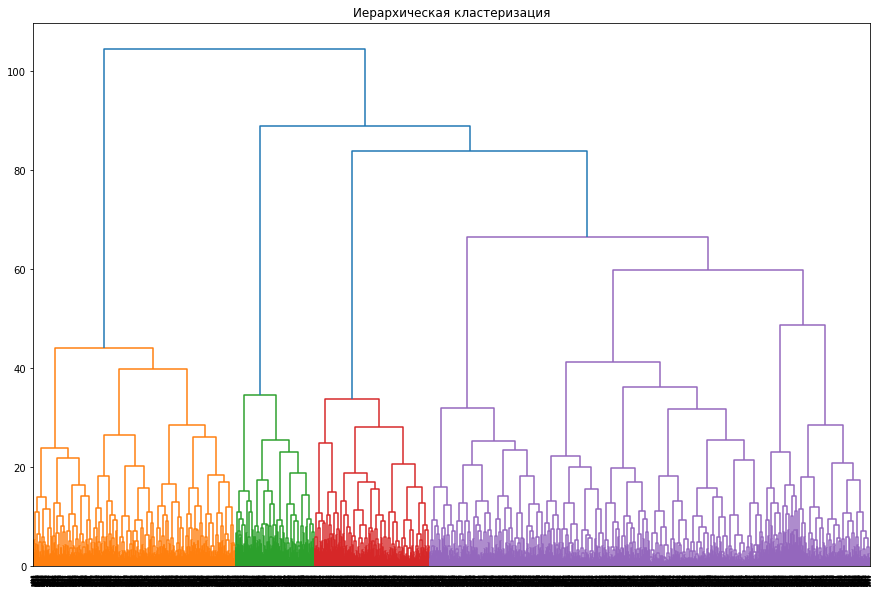

In [20]:
linked = linkage(X_sc, method='ward')
plt.figure(figsize=(15, 10))
dendrogram(linked, orientation='top')
plt.title('Иерархическая кластеризация')
plt.show()

Алгоритм предлагает оптимальное количество кластеров равное 4. Для обучения модели кластеризации на основании алгоритма K-Means, согласно ТЗ, необходимо принять количество кластеров равное 5. Спрогнозируем кластеры клиентов:

In [21]:
km = KMeans(n_clusters = 5,  random_state = 0)
labels = km.fit_predict(X_sc)
gym_churn['cluster_km'] = labels
gym_churn_mean = gym_churn.groupby('cluster_km').mean().T
gym_churn_mean

cluster_km,0,1,2,3,4
Gender,0.502970,0.522078,0.495050,0.485737,0.559666
Near_Location,0.959406,0.862338,0.000000,1.000000,0.976134
Partner,0.783168,0.470130,0.463366,0.350238,0.356802
Promo_friends,0.574257,0.306494,0.079208,0.240095,0.230310
Phone,1.000000,0.000000,1.000000,1.000000,0.998807
Contract_period,10.889109,4.787013,2.352475,1.948494,2.669451
Group_visits,0.542574,0.425974,0.215842,0.341521,0.473747
Age,29.982178,29.301299,28.477228,28.167987,30.125298
Avg_additional_charges_total,160.761016,143.957664,135.457501,131.622204,161.657905
Month_to_end_contract,9.954455,4.475325,2.198020,1.856577,2.459427


Построим распределение признаков для кластеров:

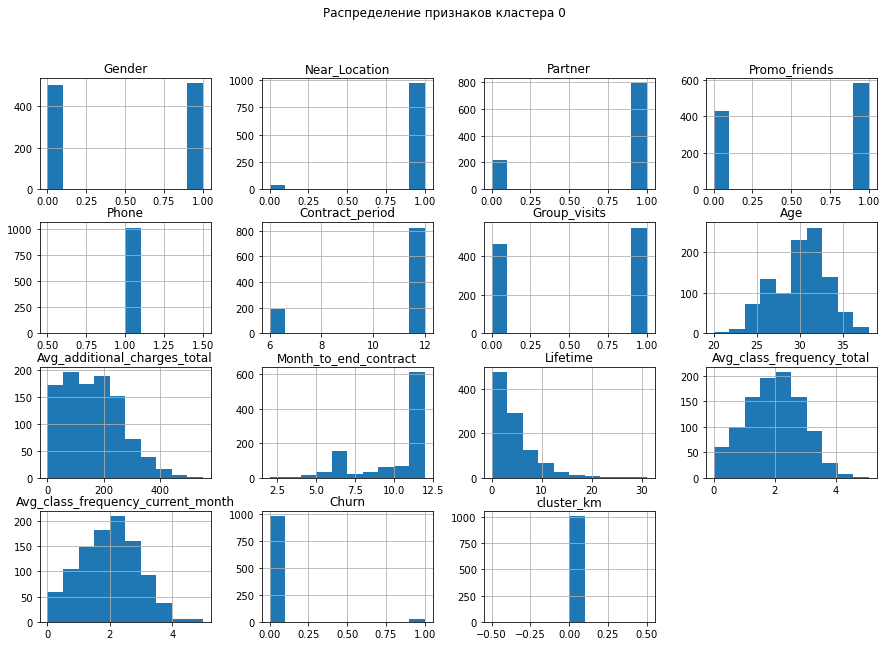

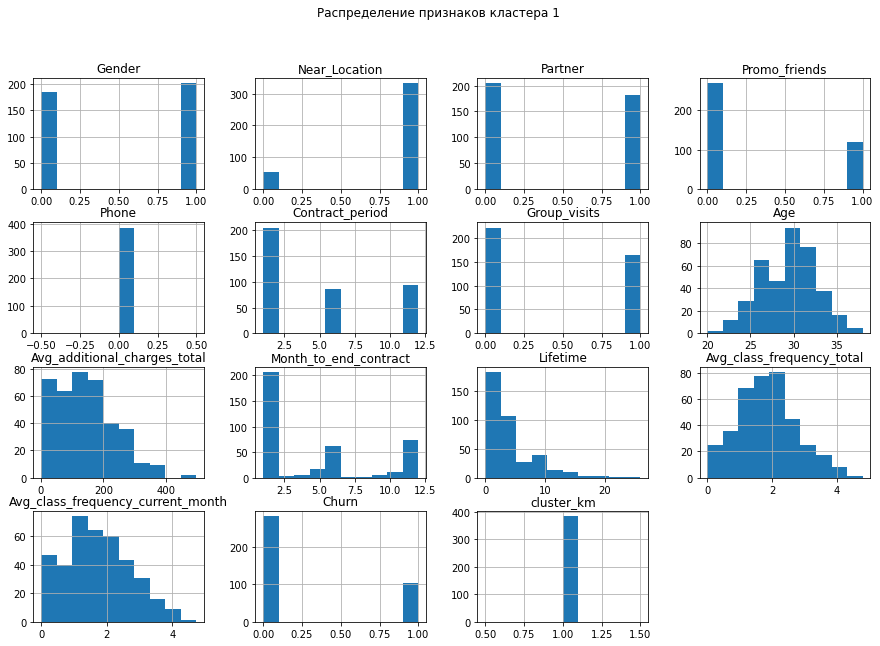

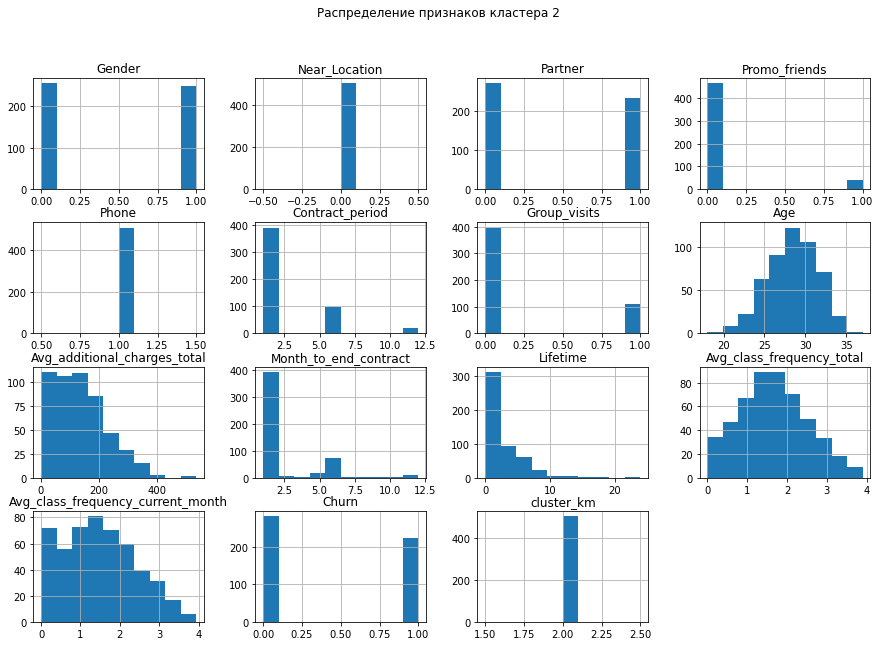

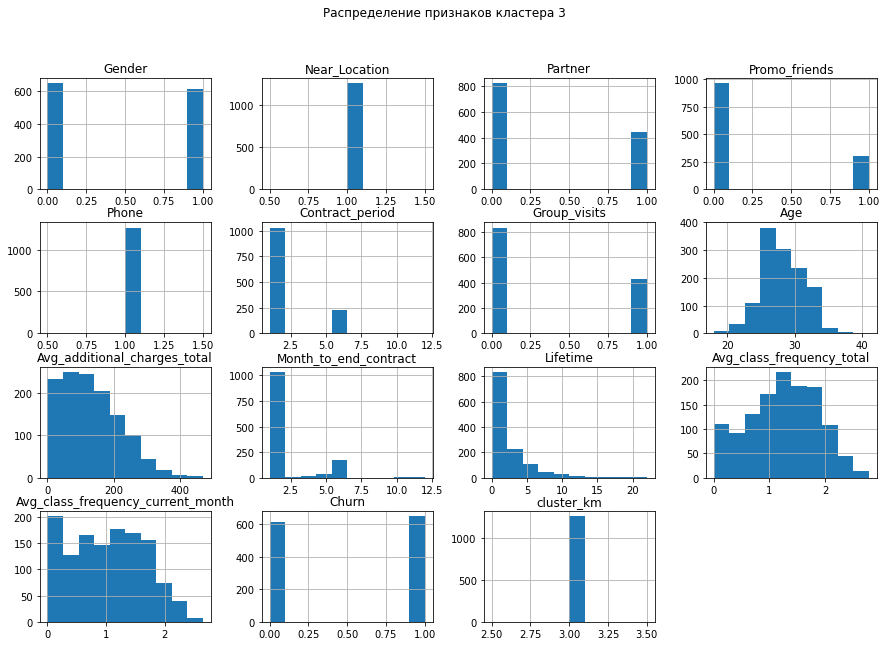

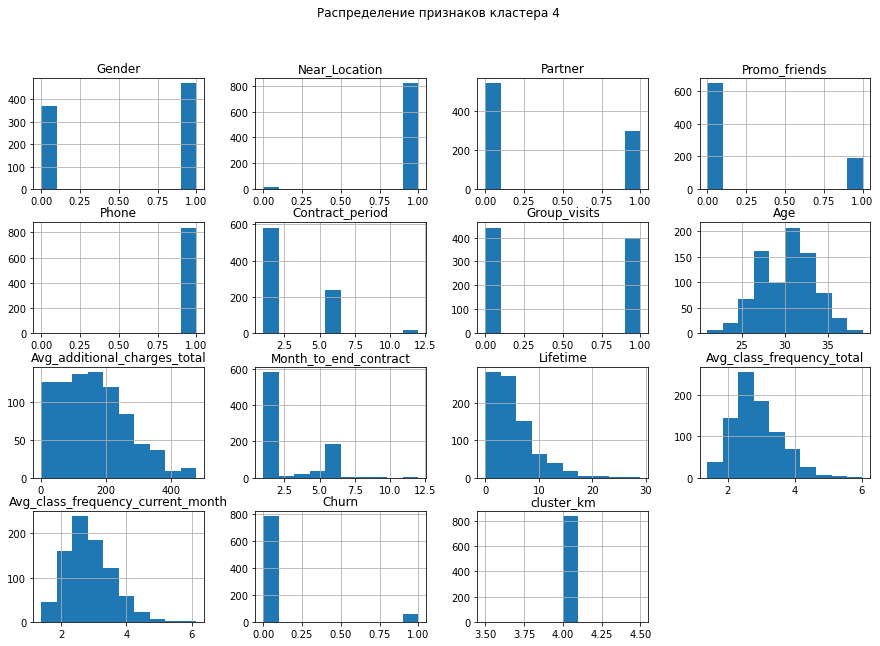

In [22]:
for row in gym_churn_mean:
    gym_churn[gym_churn['cluster_km']==row].hist(figsize=(15,10))
    plt.suptitle('Распределение признаков кластера {}'.format(row))
    plt.show()

На основании полученных данных выявлены следующие особенности кластеров клиентов:
<li>Кластер 0: самая низкая доля оттока - 2,7%; 95,9% клиентов живут или работают рядом с фитнес-центром; большинство клиентов пришли по партнерской программе (78%) либо по программе "приведи друга" (57%); клиенты занимаются по долгосрочным абонементам, половина клиентов посещает групповые занятия; среднее число посещений в неделю - 2. </li>
<li>Кластер 1: доля оттока - 26,7%; большинство клиентов - 86% жвиут или работают рядом с фитнес-центром; меньше половины - клиенты партнерской программы, треть - программы лояльности; обладатели абонементов средней продолжжительности (3-6 месяцев); 42,6% - посетители групповых занятий; клиенты посещают клуб в среднем 2 раза в неделю, или чуть реже.</li>
<li>Кластер 2: доля оттока - 44%; клиенты живут или работают в другом районе; 47% клиенты партнерской программы; по акции "приведи друга" занимаются всего 8% клиентов; абонементы карткосрочные, на 1-3 месяца; самое малое посещение групповых занятий - 21,6%; посещают клуб 1-2 раза в неделю.</li>
<li>Кластер 3: самая сщественная доля оттока - 51,4%; все клиенты живут или работают рядом; примерно треть клиентов участники партнерской программы и программы лояльности; обладатели краткосрочных абонементов, в среднем на 2 месяца; 34% посещают групповые занятия; среднее число посещений в неделю - 1.</li>
<li>Кластер 4: доля оттока - 6,8%; 97,6% клиентов живут или работают рядом; 35,6% клиентов участники партнерской программы и 23% - программы лояльности; средняя продолжительность абонемента - 2,6 месяца; почти половина клиентов посещают групповые занятия; самое большое число посещений в неделю - в среднем 3 занятия.</li>


<b>Выводы по кластеризации клиентов:</b>  
<li>клиенты были разделены на 5 кластеров</li>
<li>возраст и пол распределились приблизительно одинаково по всем кластерам</li>
<li>самые надежные кластеры - кластер 0 (склонность к оттоку 2,7%) и кластер 4 (склонность к оттоку 6,8%)</li>    
<li>наиболее склонны к оттоку кластеры 2 (44%) и 3 (51%)</li>
<li>наименее склонны к оттоку обладатели долгосрочных и среднесрочных абонементов - от 3 до 12 месяцев</li>
<li>у клиентов наиболее надежных кластеров проходит в среднем 4 месяца с момента первого посещения </li>
<li>клиенты наиболее надежных кластеров посещают занятия в среднем 2-3 раза в неделю</li>
<li>клиенты надежных кластеров также больше посещают групповые занятия, чем клиенты склонные к оттоку</li>


# Выводы и рекомендации


<b>Целевая группа клиентов:</b>  
<li>работающие или живущие рядом клиенты</li>
<li>вне зависимости от пола и возраста</li>
<li>участники партнерских программ, либо программ лояльности</li>
<li>обладатели среднесрочных и долгосрочных абонементов</li>
<li>клиенты, посещающие групповые занятия</li>

<b>Рекомендации:</b> 
<li>дальнейшая ориентация на клиентов, которые проживают или работают в районе</li> 
<li>развитие партнерских программ, путем сотрудничества с новыми компаниями</li> 
<li>развитие программ лояльности, путем поощрения действующих клиентов за каждого приведенного друга</li>
<li>развитие плана групповых занятий, преимущественно в вечернее время в будни</li>
<li>предоставление скидок или специальных предложений на среднесрочные и долгосрочные абонементы</li>
<li>предоставление рассрочки на покупку абонемента</li>
